### Загрузка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as st
import math as mth
from statsmodels.stats.proportion import proportions_ztest

In [2]:
try:
    df = pd.read_csv('datasets/bank_dataset.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net//datasets/bank_dataset.csv')

# path = '/datasets/'
# df = pd.read_csv(path + 'bank_dataset.csv')

In [3]:
df

,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15648965,771,Ярославль,М,39,5,NaN,2,1,0,96270.64,0
9996,15612628,516,Ярославль,М,35,10,57369.61,1,1,1,101699.77,0
9997,15627268,709,Ярославль,Ж,36,7,NaN,1,0,1,42085.58,1
9998,15725091,772,Ростов Великий,М,42,3,75075.31,2,1,0,92888.52,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   City              10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   Age               10000 non-null  int64  
 5   Objects           10000 non-null  int64  
 6   Balance           6383 non-null   float64
 7   Products          10000 non-null  int64  
 8   CreditCard        10000 non-null  int64  
 9   Loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  Churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [5]:
df['Balance'].isna().sum()/len(df['Balance'])# определим какой процент данных пропущен, можем ли мы удалить пропущенные значения

0.3617

In [6]:
df.duplicated().sum()

0

Нам предстоит проанализировать датафрейм(df), состоящий из 12 стобцов и 10000 строк\
Пропущены значения в столбце 'Balance' (36%)\
Дубликаты отсутствуют\
Типы данных корректны

### Предобработка данных

In [7]:
df.columns = [col.lower() for col in df.columns]
df = df.rename(columns = {'userid':'user_id','creditcard':'credit_card'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   city              10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   objects           10000 non-null  int64  
 6   balance           6383 non-null   float64
 7   products          10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


#### Обработка пропусков

count      6383.000000
mean     119827.493793
std       30095.056462
min        3768.690000
25%      100181.975000
50%      119839.690000
75%      139512.290000
max      250898.090000
Name: balance, dtype: float64


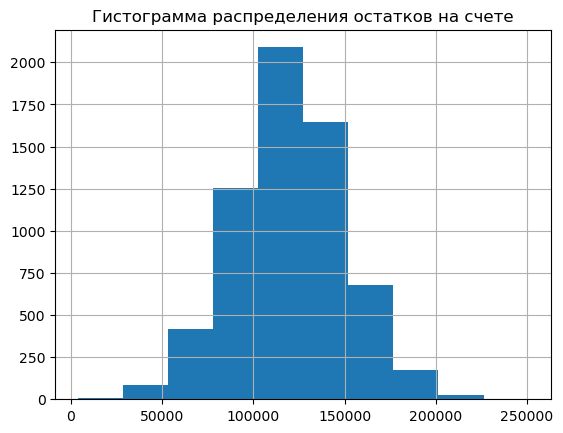

In [8]:
print(df['balance'].describe())
df['balance'].hist()
plt.title("Гистограмма распределения остатков на счете")
plt.show()

Минимальное значение 3768, значений в ноль или близких к нему не присутствует.\
Посмотрим на этот столбец с разбивкой по оттоку

In [9]:
df.groupby('churn')['balance'].apply(lambda x: x.isna().sum())

churn
0    3117
1     500
Name: balance, dtype: int64

Пропуски в основном у оставшихся клиентов\
Возможно, они пользуются кредитками и не хранят собственные средства?

In [10]:
df.groupby('credit_card')['balance'].apply(lambda x: x.isna().sum())

credit_card
0    1025
1    2592
Name: balance, dtype: int64

In [11]:
df.groupby('products')['balance'].apply(lambda x: x.isna().sum())
# df['products'].value_counts()

products
1     905
2    2600
3      98
4      14
Name: balance, dtype: int64

На основе этого анализа, мы можем сделать предположение, что пропуски - скорее всего означают отсутствие собственных средств на счету.\
Эти клиенты пользуются продуктами, что скорее всего кредитка и какая- то еще кредитная линия(ипотека), то есть клиент пользуется только заемными средствами\
Пропуски оставим на месте

### Анализ данных

In [12]:
gender_dict = {'Ж':0,'М':1} # для замены на бинарные величины
df_by_gender = df.replace({'gender':gender_dict})
df_by_gender

,user_id,score,city,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
0,15677338,619,Ярославль,0,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,0,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,0,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,0,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,Рыбинск,0,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15648965,771,Ярославль,1,39,5,NaN,2,1,0,96270.64,0
9996,15612628,516,Ярославль,1,35,10,57369.61,1,1,1,101699.77,0
9997,15627268,709,Ярославль,0,36,7,NaN,1,0,1,42085.58,1
9998,15725091,772,Ростов Великий,1,42,3,75075.31,2,1,0,92888.52,1


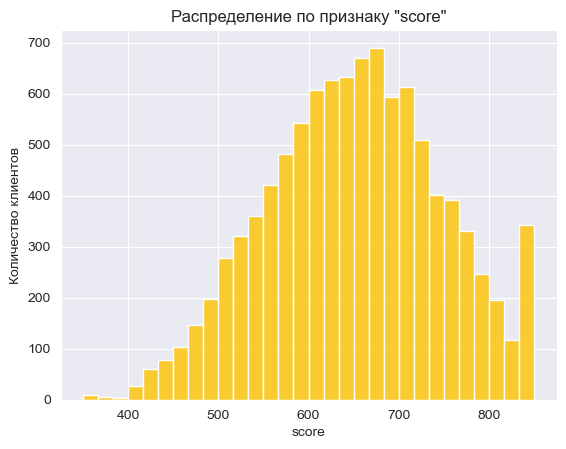

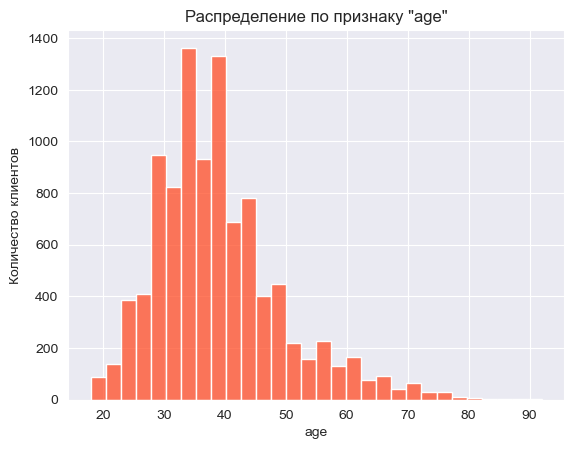

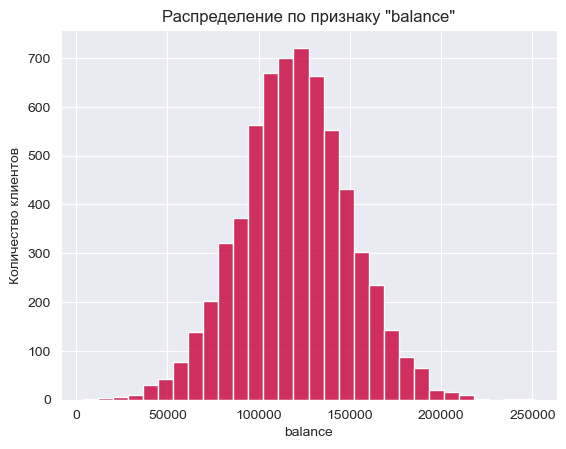

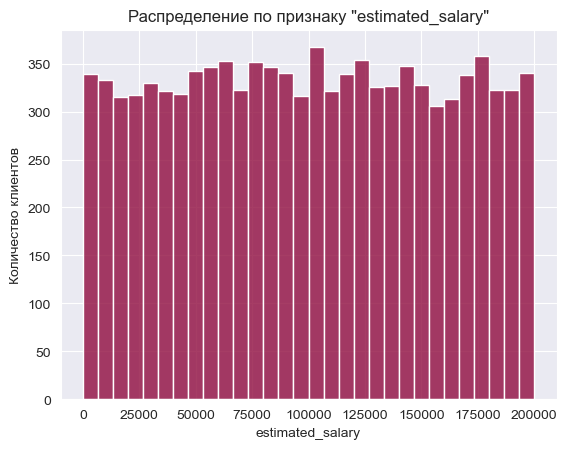

In [13]:
new_df = df.drop('user_id', axis=1)
df_quantity = new_df[['score', 'age', 'balance', 'estimated_salary']]

palette = ['#FFC300', '#FF5733', '#C70039', '#900C3F']

with sns.axes_style('darkgrid'):
    for att, color in zip(df_quantity.columns, palette):
        A = df[att]
        A_without_nan = A[~np.isnan(A)]
    
        sns.histplot(A_without_nan, kde=False, bins=30, color=color, alpha=0.8)
        plt.title(f'Распределение по признаку "{att}"')
        plt.xlabel(att)
        plt.ylabel('Количество клиентов')
        plt.show()

Из аномалий, наблюдаем, всплеск значений кредитного скоринга на значениях выше 830 (при максимуме 850).\
Кредитная линия как будто ограничена, и клиенты которые могли получить больше превращаются в выброс\
Зарплаты клиентов имееют однородное распределение, как будто была специально подобрана равная группа.

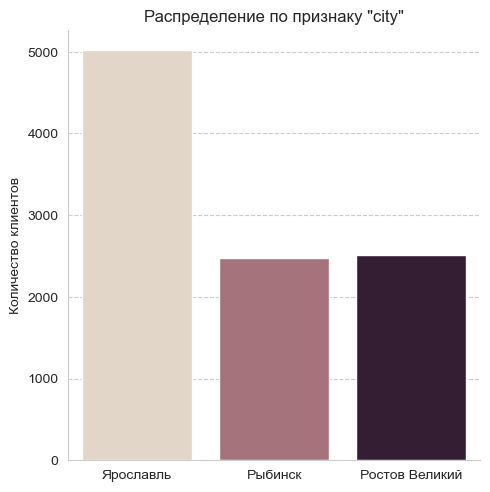

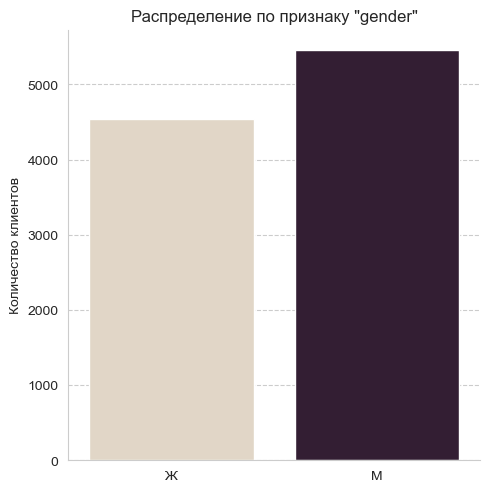

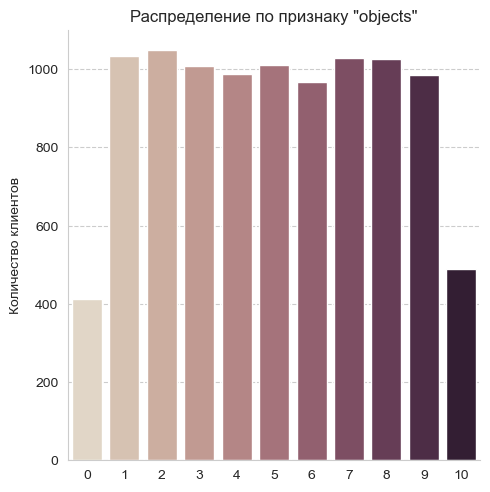

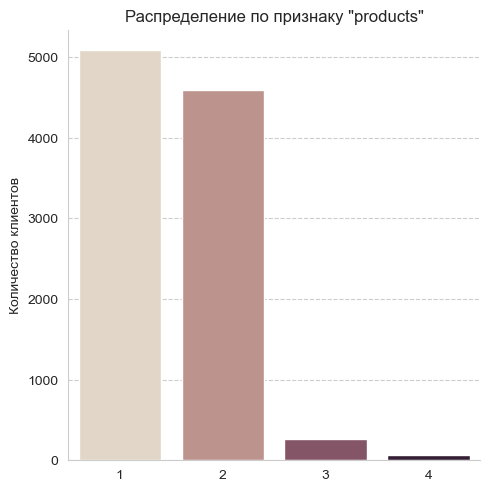

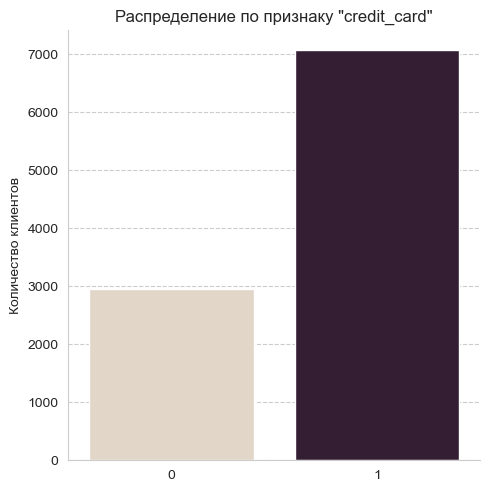

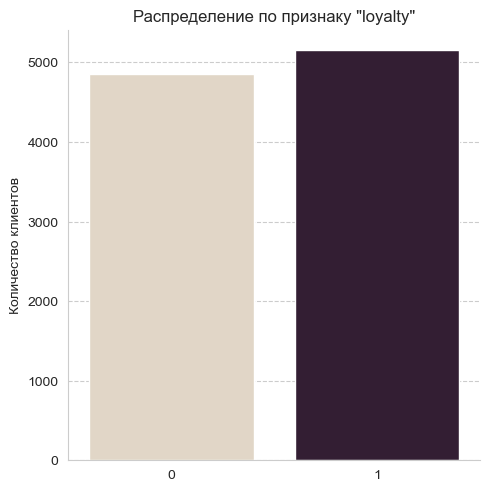

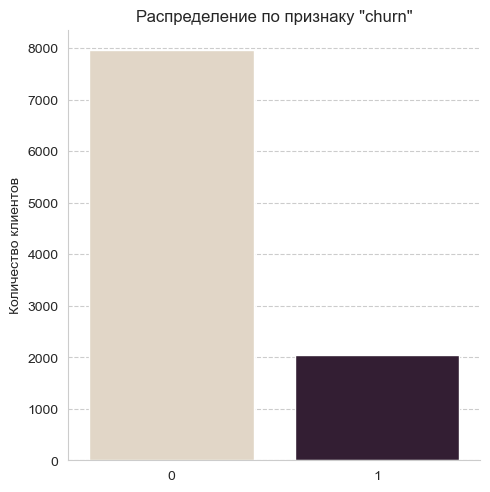

In [14]:
df_categorial = new_df[['city', 'gender', 'objects', 'products', 'credit_card', 'loyalty', 'churn']]
with sns.axes_style('whitegrid'):
    for att in df_categorial.columns:
        sns.catplot(x=att, kind='count', palette="ch:.25", data=df)
        plt.title(f'Распределение по признаку "{att}"')
        plt.xlabel('')
        plt.ylabel('Количество клиентов')
        plt.grid(True, axis='y', linestyle='--')
        plt.show()#распределение по категориальным признакам

# df_categorial = new_df[['city', 'gender', 'objects', 'products', 'credit_card', 'loyalty', 'churn']]
# num_cols = 3 
# num_rows = int(np.ceil(len(df_categorial.columns) / num_cols)) 

# fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
# axs = axs.flatten()  


# for i, att in enumerate(df_categorial.columns):
#     values, counts = np.unique(df_categorial[att], return_counts=True)
#     pie, _, _ = axs[i].pie(counts, labels=values, autopct='%1.1f%%', startangle=90, counterclock=False)
#     axs[i].set_title(f'Распределение по признаку "{att}"')

    
#     if i == 2 or i == 3:
#         axs[i].legend(pie, labels=values, loc="center right", bbox_to_anchor=(1.2, 0.5))

# for i in range(len(df_categorial.columns), num_rows*num_cols):
#     axs[i].axis('off')

# plt.show()

**Общий портрет клиента:**\
Большинство людей из областного центра (Ярославля). Рыбинск и Ростов примерно поровну.\
Соотношение полов 55:45 в пользу мужчин.\
По количеству объектов собственности распределение почти однородное с исключениями в 0 и 10(400 единиц).\
Тоже имеет место быть предположение об искусственной выборке\
Подавляющее большинство клиентов в выборке пользуются 1 или 2 продуктами.\
Кредитками пользуются 71% клиентов.\
Отток составляет 20%.\
Лояльность 52%.

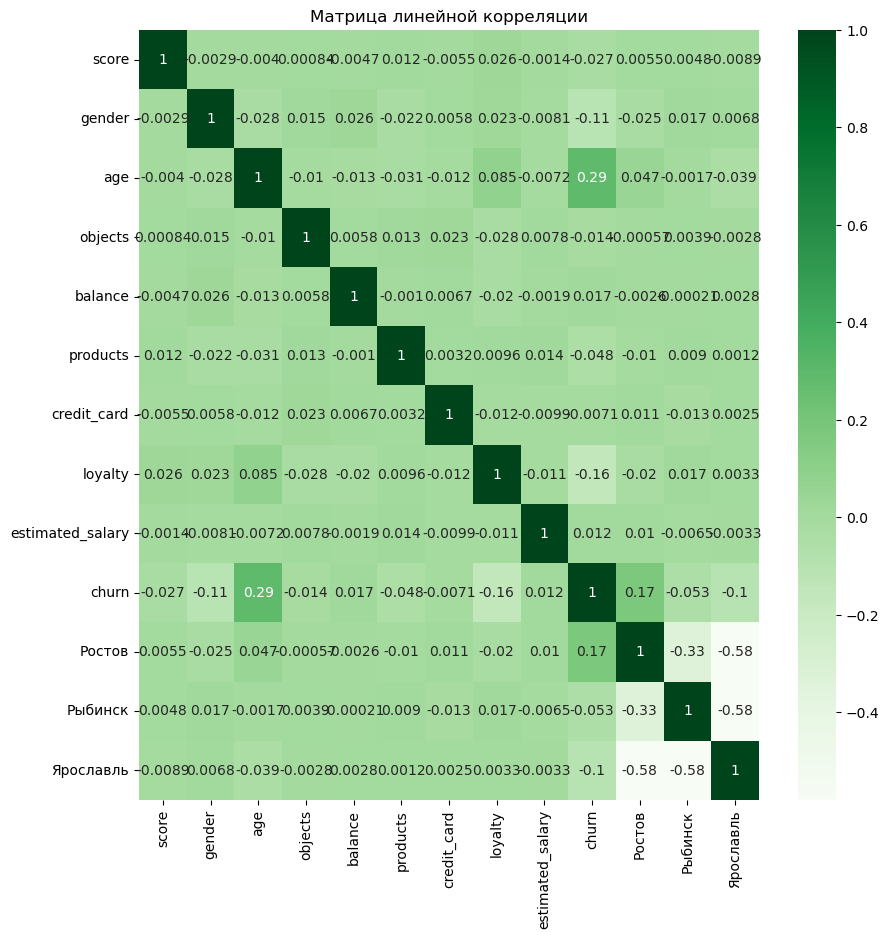

In [15]:
gender_dict = {'Ж':0,'М':1}
corr_df = df.drop('user_id', axis=1).replace({'gender':gender_dict})
corr_df['Ростов'] = (corr_df['city'] == 'Ростов Великий').astype(int)
corr_df['Рыбинск'] = (corr_df['city'] == 'Рыбинск').astype(int)
corr_df['Ярославль'] = (corr_df['city'] == 'Ярославль').astype(int)
plt.figure(figsize = (10,10))
sns.heatmap(corr_df.corr(), annot=True, cmap='Greens')
plt.title('Матрица линейной корреляции')
plt.show()

По шкал Чеддока между столбцами очень слабая корреляция(не учитывается в расчете) , кроме связи между возрастом и оттоком там она слабая(почти умеренная),ее мы можем брать в расчет


### Портрет клиента, склонного к оттоку

In [16]:
df_left = df.query('churn == 1')#отток
df_stayed = df.query('churn == 0')#оставшиеся

In [17]:
def churn_hist(att):
    A = df_stayed[att]
    A_not_nan = A[~np.isnan(A)]
    B = df_left[att]
    B_not_nan = B[~np.isnan(B)]

    sns.distplot(B_not_nan, kde=False, bins=25, norm_hist=True)
    sns.distplot(A_not_nan, kde=False, bins=25, norm_hist=True)
    plt.title(f'Распределение по признаку "{att}"')
    plt.xlabel(att)
    plt.ylabel('Количество клиентов')
    plt.legend(labels = ['Клиент ушел', 'Клиент остался'])
    plt.grid(axis='y', linestyle='--')
    ax = plt.gca()

D:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


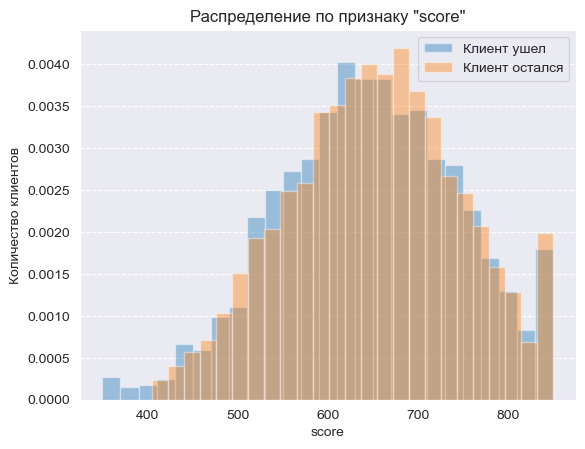

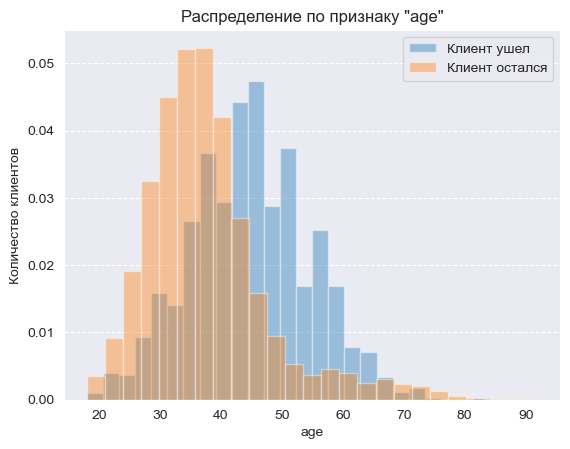

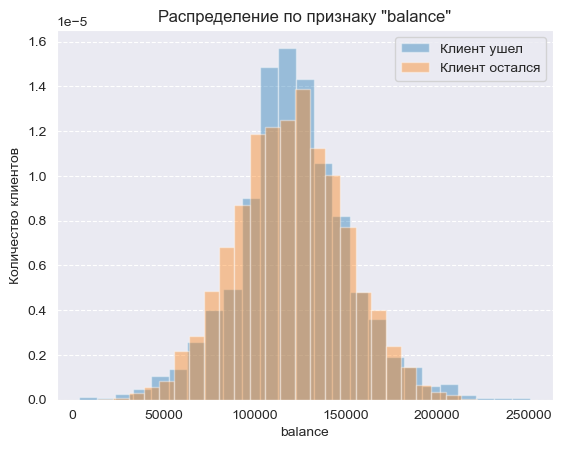

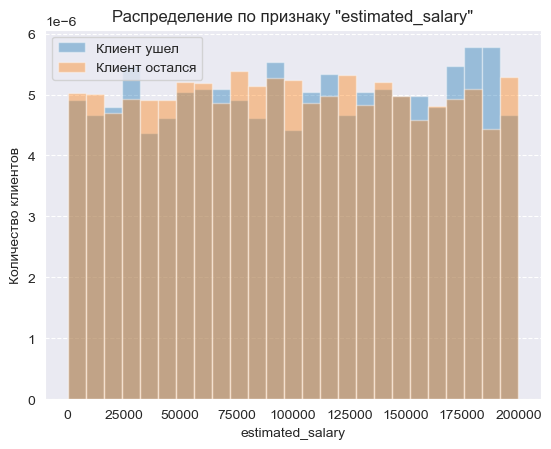

In [18]:
with sns.axes_style('dark'):
    for att in df_quantity.columns:
        churn_hist(att)
        plt.show()

Можем отметить заметные различия по параметру возраст\
После 40 клиенты уходят намного чаще, можем предположить, что банк делает ставку на молодых клиентов, больше предложений, мало отделений, основная ставка на приложение(что неудобно пожилым клиентам)\
Немного чаще уходят люди с остатками на счете от 100 до 150 тыс, а также больше 200 тыс.

In [19]:
def categorial(att):
    
    total = df[att].value_counts().sort_index()
    left_clients = df_left[att].value_counts().sort_index()
    percentage = (left_clients / total).sort_index()
    
    barplot1 = total.plot(kind='bar', color='#ffc107')
    barplot2 = left_clients.plot(kind='bar', color='#ff3d00')
    for i, rect in enumerate(barplot2.patches):
        n = int(len(barplot2.patches) / 2.0) 
        if i >= n:
            height = rect.get_height()

            plt.text(rect.get_x() + rect.get_width() / 2.0, height / 3.0, f'{percentage.iloc[int(i-n)]:1.1%}', 
                     ha='center', va='bottom', color='black')
   
    plt.title(f'Распределение по признаку "{att}"')
    plt.xlabel('')
    plt.xticks(rotation=360)
    plt.ylabel('Количество клиентов')
    plt.grid(axis='y', linestyle='--')
    plt.legend(['Клиент остался', 'Клиент ушел'])
    
#     for i, patch in enumerate(barplot2.patches):
#         x, y = patch.get_xy()
#         width, height = patch.get_width(), patch.get_height()
#         plt.text(x+width/2, y+height+0.01, '{:.1%}'.format(percentage[i]), ha='center')

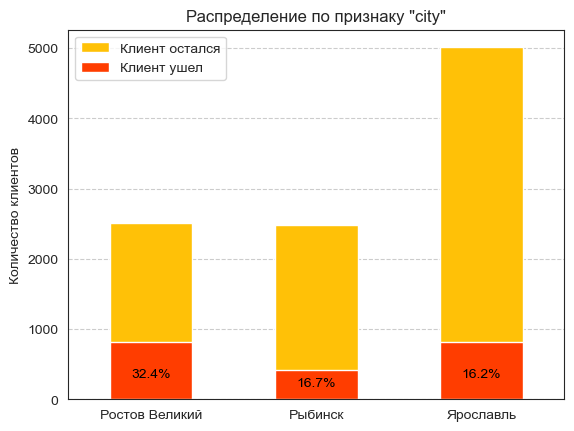

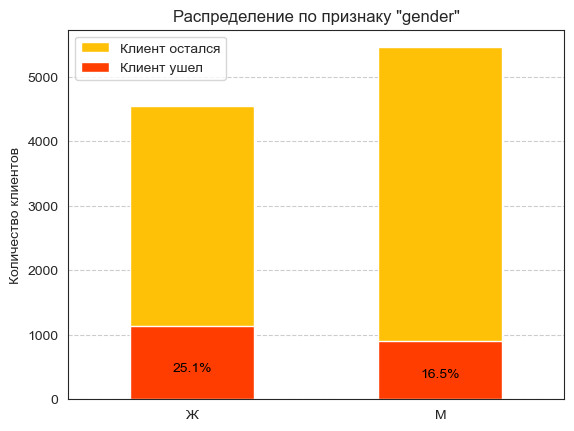

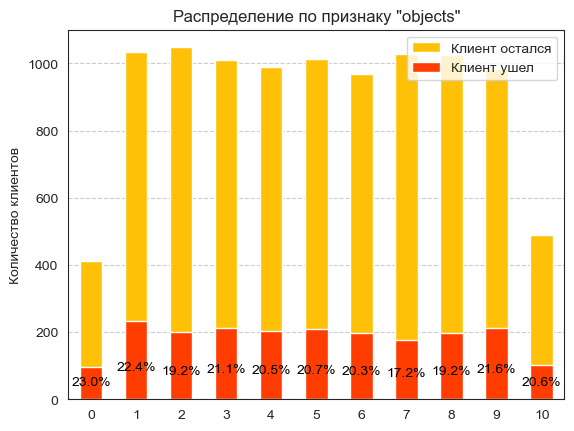

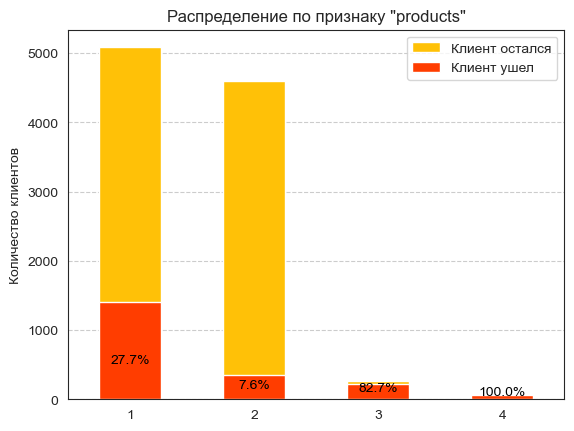

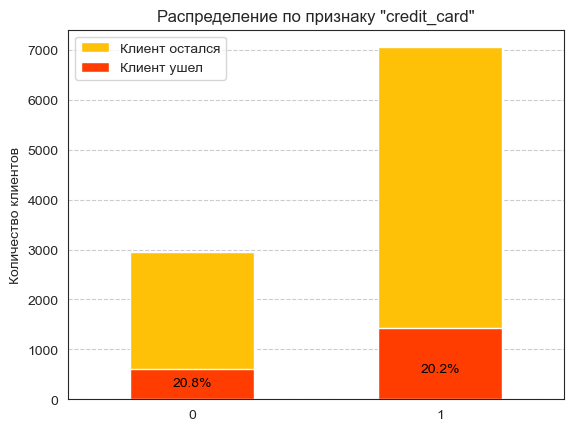

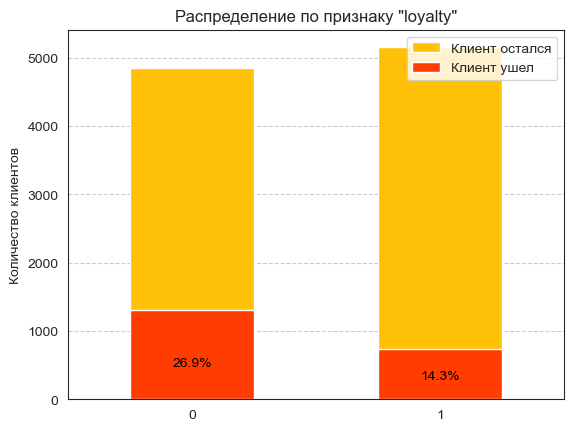

In [20]:
with sns.axes_style('white'):
    for att in df_categorial.drop('churn', axis=1).columns:
        categorial(att)
        plt.show()

Высокий процент оттока:\
в Ростове (32.4%)\
среди женщин (25.1%)\
для тех у кого 3 (82.7%), 4 продукта (100%), заметно ниже у клиентов с 1 продуктом(27,7%)\
среди нелояльных клиентов (26.9%)\

Низкий процент оттока:\
в Рыбинске и Ярославле (16.7%)\
среди мужчин (16.5%)\
для людей пользующихся ровно 2 продуктами (7.6%)\
для лояльных клиентов (14.3%)

**Выводы:**

Портрет клиента склонного к оттоку:\
Проживает в Ростове Великом\
Женщина\
Старше 40\
Использует 3-4 продукта (реже 1)\
Нелояльна\
Владеет 0-1 объектом собственности\
Остаток на счете 100-150 тысыя или больше 200 тысяч\

Портрет клиента склонного остаться:\
Проживает в Ярославле или Рыбинске\
Мужчина\
Моложе 40\
Использует 2 продукта\
Лоялен\
В собственности больше 1 объекта\
Остаток на счете  75-100 тысяч или  150-200 тысяч\

### Проверка гипотез

#### Проверить гипотезу различия дохода между теми клиентами, которые ушли и теми, которые остались

H0: различий в доходе клиентов в группах  "ушел" и "остался" нет

H1: различия в доходе клиентов в группах  "ушел" и "остался" есть

Будем проверять гипотезу при помощи теста Манна-Уитни, т.к у нас почти одинаковые формы распределения

In [21]:
alpha = .05 
def hypothesis_1 (data1, data2, alpha):
    
    print(f'Уровень значимости теста = {alpha}')
    p_v = st.mannwhitneyu(data1, data2).pvalue
    
    print("pvalue = {0:.15f}".format(p_v))
    if (p_v < alpha):
        print('Статистически значимая разница')
    else:
        print('Нет статистически значимой разницы')

hypothesis_1(df_left['estimated_salary'], df_stayed['estimated_salary'], alpha)       

Уровень значимости теста = 0.05
pvalue = 0.227051509301538
Нет статистически значимой разницы


Мы принимаем нулевую гипотезу

#### Проверить гипотезу различия доли оттока между лояльными и нелояльными клиентами

H0: доли оттока равны для лояльных и нелояльных клиентов

H1: доли оттока различны для лояльных и нелояльных клиентов

Будем проверять при помощи Z-тест, так нам надо сравнить доли

In [22]:
# def hypothesis_2(dep_cat, ind_cat, alpha):
    
#     group_size = df[ind_cat].value_counts() 
#     share_size = df.groupby(ind_cat)[dep_cat].sum() 
   
    
#     p = share_size / group_size 
#     p_combined = share_size.sum() / group_size.sum() 
    
#     difference = p[0] - p[1]
    
#     z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/group_size[0] + 1/group_size[1]))

  
#     distr = st.norm(0, 1) 

#     p_value = (1 - distr.cdf(abs(z_value))) * 2

#     print(f'Уровень значимости: {alpha}')
#     print('p-значение: {0:.15f}'.format(p_value))

#     if (p_value < alpha):
#         print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
#     else:
#         print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")

# hypothesis_2('churn', 'loyalty', .05)

def hypothesis_2(dep_cat, ind_cat, alpha):
    group_sizes = df[ind_cat].value_counts()
    success_counts = df.groupby(ind_cat)[dep_cat].sum()
    nobs = group_sizes.values
    successes = success_counts.values
    
    z_value, p_value = proportions_ztest(successes, nobs, value=0, alternative='two-sided')
    
    print(f'Уровень значимости: {alpha}')
    print(f'p-значение: {p_value:.15f}')
    
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
        
hypothesis_2('churn', 'loyalty', .05)

Уровень значимости: 0.05
p-значение: 0.000000000000000
Отвергаем нулевую гипотезу: между долями есть значимая разница


### Выводы и рекомендации

Самые явные признаки по оттоку:

Лояльность - 0\
Возраст - старше 40\
Пол - женский\
Город - Ростов\

К оттоку оказались наиболее склонны нелояльные женщины старше 40, проживающие в Ростове Великом, пользующиеся 3-4 продуктами банка(реже 1), владеющие 1 объектом собственности или не владеющие вовсе, зарабатывающие 100-150 тысяч\.

Наоборот, чаще всего остаются с банком лояльные мужчины моложе 40, проживающие в Ярославле и Рыбинске, пользующиеся двумя продуктами банка, владеющие более, чем одним объектом, зарабатывающие  75-100 тысяч или 150-200 тысяч.\

По гипотезе о различии доходов между клиентами, которые ушли и которые остались:\
Мы не можем утверждать, что между группами есть статистически значимое различие доходов\

По гипотезе о различии доли клиентов, кто ушел, среди и лояльных клиентов:\
Между долями есть значимая разница, лояльные клиенты уходят реже\

**Рекомендации:**\
Стоит сосредоточиться на работе в Ростове,выявить проблемы, определить различия в работе между городами\
Акцентировать внимание на работу с населением до 40 лет.\
В тоже время исследовать причины увеличения оттока среди старшего населения и принять адекватные меры.\
Сконцентрироваться на привлечении клиентов мужчин.\
Разработать комплекс мер для увеличения лояльности женского населения, выявить проблемы(через опросы или анализ)\
Проверить методы сбора информации и формирования выборки.

**Ссылки на дополнительные материалы:**\
Презентация: https://disk.yandex.ru/i/TqJhKpz5c0sKlQ \
Дашбоард:https://public.tableau.com/views/Blinkov_final_project/Dashboard1?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link